# NO2 over Siberian pipelines

ESA has recently published an [article](https://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-5P/Connecting_the_dots_nitrogen_dioxide_over_Siberian_pipelines) on NO2 leakage detection over the compression plants that transport gas along siberian pipelines using Sentinel 5P data. According to the article, NO2 detection on snow covered areas from satellite images is very dificult to distinguish as it has the same signal as clouds. With Sentinel 5P is now possible to detect such leaks even during snow covered months. 

There is little information and no reproducible methodology in the article, so we give it a go with the Sentinel 5P collections we have in TOP Platform. 

In [8]:
import geopandas as gpd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import adampy as adam
import rasterio
import warnings
warnings.filterwarnings("ignore")


Using Adampy we can easily get the data from the TOP Platform servers by defining a bbox, time and collection

In [2]:
collection = 'vr_S5P_RPROOFFLNRTI_L2_NO2_PRODUCT_NITROGENDIOXIDE_TROPOSPHERIC_COLUMN'

time_t = '2019-04-01T00:00:00,2019-04-15T23:59:59'

max_lat = 70
min_lat = 59

max_long = 85
min_long = 50.0

image, metadata = adam.getImageSentinel5p('wcs.top-platform.eu', collection,time_t,scale = 1, max_lat = max_lat, min_lat = min_lat, min_long = min_long, max_long = max_long).get_data()

We get back a numpy array that can be easily plotted with Matplotlib (or any other plotting package)

Text(0.5, 1.0, 'S5P NO2 in mol/m²')

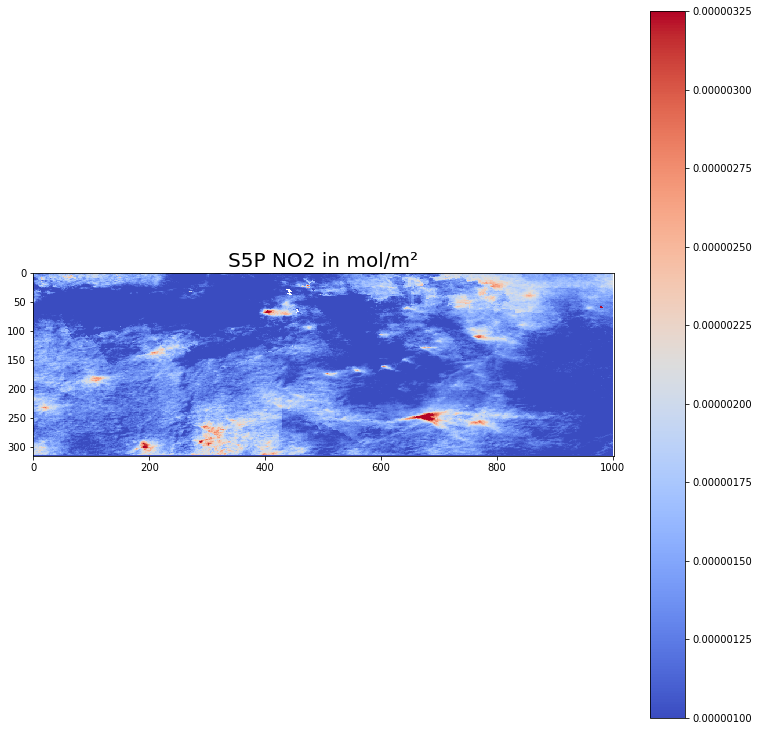

In [3]:
plt.subplots(figsize=(13,13))

plt.imshow(image, cmap = 'coolwarm')
plt.colorbar()
plt.clim(0.000001,0.00000325)
plt.title('S5P {} in mol/m²'.format(collection.split('_')[-1]), size=20)

In [4]:
metadata.update({"dtype" : 'float32'})
new_dataset = rasterio.open('gas.tif', 'w', **metadata)

new_dataset.write(image, 1)
new_dataset.close()

We can also add it to a more interactive map environment like Folium

In [5]:
import folium
from folium.plugins import Draw
from folium import plugins
import branca.colormap as cm
import matplotlib
import matplotlib.pyplot as plt

print(folium.__version__)

0.8.3


In [9]:
# create the map
m = folium.Map(location=[65, 65], zoom_start = 4)

#transform data from kelvin to celsius
data = image

#we define the colormap
cmm = matplotlib.cm.get_cmap('coolwarm')

#normalized the data and colorize the data according to the colormap
#normed_data = (data - data.min()) / (data.max() - data.min())
normed_data = (data - 0.000001) / (0.00000325 - 0.000001)

colored_data = cmm(normed_data)

# read in png file to numpy array



#print(anomaly)
# Overlay the image
folium.raster_layers.ImageOverlay(colored_data, 
                                  opacity=0.7,
                                  bounds =[[min_lat, min_long], [max_lat, max_long]],
                                  
                                 ).add_to(m)

#add the colorbar
#minval = 0.000001
#maxval = 0.00000325

#colormap = cm.linear.Spectral_03.scale(minval,maxval).to_step(10)
#colormap.caption = 'Temperatures in [C]'
#m.add_child(colormap)


# Define a Javascript function that formats the coordinate value
# that is passed to it.
formatter = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"

plugins.MousePosition(
    position='bottomright',
    separator=' | ',
    empty_string='NaN',
    lng_first=True,
    num_digits=20,
    prefix='Coordinates:',
    lat_formatter=formatter,
    lng_formatter=formatter
).add_to(m)

#add a measure pluggin
m.add_child(plugins.MeasureControl(position='bottomleft'))

#add drawing plugin
draw = plugins.Draw(export=True)

draw.add_to(m)

m